In [54]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import random
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.display.ds9 as ds9
import lsst.afw.table as afwTable

import DiaSourceTools as DSTools
import lsst.afw.display.utils as displayUtils
import lsst.meas.algorithms.detection as sDet

%matplotlib inline

In [212]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")

subset = butler.subset("deepDiff_diaSrc")
#file = open("diaSources.txt", "w")
diaSourcesList = []
for dr_subSet in subset:
    if dr_subSet.dataId["ccd"]==14:
        #file.write("visit="+str(dr_subSet.dataId["visit"])+"\n")
        try:
            diaSourcesList.append(dr_subSet)
           
        except:
            pass

In [381]:
visit = visits[0]

dataId = {'visit': visit , 'filter':'r' , 'ccd':14}
diaSrcs = butler.get("deepDiff_diaSrc", dataId)
diffExp = butler.get("deepDiff_differenceExp", dataId)
sciExp  = butler.get("calexp", dataId)
tmpExp = butler.get("deepDiff_warpedExp", dataId)
bgConf = sDet.BackgroundConfig()
background,tmpExp = sDet.estimateBackground(tmpExp,bgConf,True)

In [382]:
fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

m_sigma = np.mean(sigmas)
t_sigma = 5*m_sigma

sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")
print len(sources)

89


In [367]:
mosaic_dif = displayUtils.Mosaic(gutter=3, background=3, mode="square")
mosaic_sci = displayUtils.Mosaic(gutter=3, background=3, mode="square")
mosaic_tmp = displayUtils.Mosaic(gutter=3, background=3, mode="square")

for i, source in enumerate(sources):
    try:
        dif_stamp = DSTools.get_stamp(source, diffExp)
        
        negFlux   = np.abs(source.get("ip_diffim_PsfDipoleFlux_neg_flux"))
        posFlux   = np.abs(source.get("ip_diffim_PsfDipoleFlux_pos_flux"))
        totalFlux=negFlux+posFlux
        passesFluxNeg = (negFlux / totalFlux)
        passesFluxPos = (posFlux / totalFlux)
        
        mosaic_dif.append(dif_stamp.getMaskedImage(), label=str(i)+"-"+str(source.get("classification_dipole")))
        
        sci_stamp = DSTools.get_stamp(source, sciExp)
        mosaic_sci.append(sci_stamp.getMaskedImage(), label=str(i))

        
        tmp_stamp = DSTools.get_stamp(source, tmpExp)
        mosaic_tmp.append(tmp_stamp.getMaskedImage(), label=str(i))
    except Exception, e:
        print e


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1777,2257),Extent2I(274,347)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1777,2257),Extent2I(274,347)) doesn't fit in image 2048x4612'



In [383]:
mosaic_dif.makeMosaic(frame=1, title="mosaic_dif")
ds9.setMaskTransparency(100, frame=1)
mosaic_sci.makeMosaic(frame=2, title="mosaic_science")
ds9.setMaskTransparency(100, frame=2)
mosaic_tmp.makeMosaic(frame=3, title="mosaic_template")
ds9.setMaskTransparency(100, frame=3)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


In [384]:
ds9.mtv(diffExp, frame=4)

for i, s in enumerate(sources):
    ds9.dot(i, s.getX()-1, s.getY()-1, frame=4)

In [ ]:
reload(DSTools)

In [ ]:
for i, s in enumerate(sources):
    try:
        print "===========Source # "+ str(i) +"=============="
        te_stamp = DSTools.get_stamp(s, diffExp)
        print "negative lobe"
        DSTools.plot_cumulative_flux(te_stamp, "DETECTED_NEGATIVE", positive=False)
        print "positive lobe"
        DSTools.plot_cumulative_flux(te_stamp, "DETECTED")
    except Exception, e:
        print e

In [ ]:
ds9.mtv(sciExp, frame=6)

In [ ]:
dipoles_pos = []
dipoles_neg = []
maybe_dipoles_pos = []
maybe_dipoles_neg = []
rejected_dipoles_pos = []
rejected_dipoles_neg = []
others_pos = []
others_neg = []
transients = []

In [ ]:
transient = 20

In [321]:
for i, s in enumerate(sources):
    try:
        stamp = DSTools.get_stamp(s, diffExp)
        stamp_clone = stamp.clone()
        results = DSTools.detect_diasources(stamp_clone, doSmooth=True)
        negFps = len(results.fpSets.negative.getFootprints())
        posFps = len(results.fpSets.positive.getFootprints())
        pos_flux_at_25 = get_flux_percentage_at(stamp)
        neg_flux_at_25 = get_flux_percentage_at(stamp, plane_mask="DETECTED_NEGATIVE")
        
        if i == transient:            
            transients.append(pos_flux_at_25)
        elif negFps >0 and posFps>0:
            if DSTools.get_naive_dipole_probability(s) == 1.0:
                dipoles_pos.append(pos_flux_at_25)
                dipoles_neg.append(neg_flux_at_25)
            elif np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
            
                maybe_dipoles_pos.append(pos_flux_at_25)
                maybe_dipoles_neg.append(neg_flux_at_25)
            else:
                rejected_dipoles_pos.append(pos_flux_at_25)
                rejected_dipoles_neg.append(neg_flux_at_25)
        else: 
            #print i
            #print "by default pos", pos_flux_at_25
            #print "by default neg", neg_flux_at_25
            if pos_flux_at_25 is not None:
                
                others_pos.append(pos_flux_at_25)
            else:
                
                others_neg.append(neg_flux_at_25)
                
        
    except Exception, e:
        print e


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1855,2226),Extent2I(195,137)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1855,2226),Extent2I(195,137)) doesn't fit in image 2048x4612'



In [322]:
#print dipoles_pos
#print dipoles_neg
#print maybe_dipoles_pos
#print maybe_dipoles_neg
#print rejected_dipoles_neg
#print rejected_dipoles_pos
#print others_pos
#print others_neg
print transients

[0.61072212775659573, 0.58797682386826899, 0.63716870569514317, 0.71246185740110668, 0.95040064464655605]


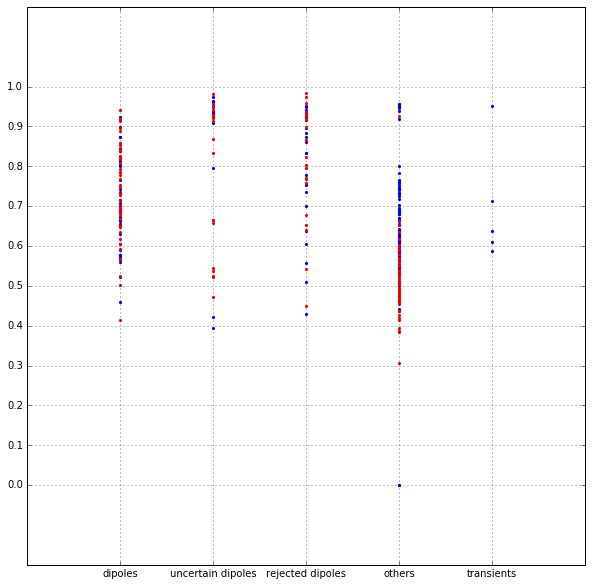

In [324]:
size = 10
p = 'b'
n = 'r'

plt.figure(figsize=(10,10))
plt.scatter([1 for val in dipoles_pos], dipoles_pos, s=size, c=p, lw=0)
plt.scatter([1 for val in dipoles_neg], dipoles_neg, s=size, c=n, lw=0)

plt.scatter([2 for val in maybe_dipoles_pos], maybe_dipoles_pos , s=size, c=p, lw=0)
plt.scatter([2 for val in maybe_dipoles_neg], maybe_dipoles_neg , s=size, c=n, lw=0)

plt.scatter([3 for val in rejected_dipoles_pos], rejected_dipoles_pos , s=size, c=p, lw=0)
plt.scatter([3 for val in rejected_dipoles_neg], rejected_dipoles_neg , s=size, c=n, lw=0)

plt.scatter([4 for val in others_pos], others_pos , s=size, c=p, lw=0)
plt.scatter([4 for val in others_neg], others_neg , s=size, c=n, lw=0)

plt.scatter([5 for val in transients], transients, s=size, lw=0)

plt.xticks([1,2,3,4, 5], ["dipoles", "uncertain dipoles", "rejected dipoles",  "others", "transients"])

plt.yticks(np.arange(0, 1.1, 0.1))

axes = plt.axes()
axes.grid(True)

plt.show()

In [199]:
def get_flux_percentage_at(stamp, percent = 0.25, plane_mask="DETECTED", positive=True):
    
    cumsum = DSTools.get_cumulative_flux(stamp, plane_mask=plane_mask, positive=positive)
    
    if cumsum is None:
        return None
    
    total = float(len(cumsum))
    
    for i, value in enumerate(cumsum):
        #print i, float(i+1)/total, 1-value
        if float(i+1)/total > (1-percent):
            return 1-value

0.57740730663
0.579036010867
0.254098360656 30
75% of sources contribute 95.1357749525% of total flux
50% of sources contribute 81.697957735% of total flux
25% of sources contribute 57.740730663% of total flux
10% of sources contribute 33.526750733% of total flux


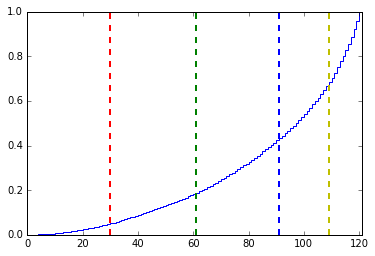

array([  8.11916301e-05,   3.46057864e-04,   6.11998594e-04,
         9.03598923e-04,   1.31477299e-03,   1.78132367e-03,
         2.28734203e-03,   2.84897760e-03,   3.42594478e-03,
         4.36965178e-03,   5.35117462e-03,   6.56480451e-03,
         7.82710745e-03,   9.21037936e-03,   1.07633895e-02,
         1.23917748e-02,   1.41262143e-02,   1.59426524e-02,
         1.78478085e-02,   1.98405760e-02,   2.19008765e-02,
         2.41259597e-02,   2.66040946e-02,   2.91646610e-02,
         3.17986139e-02,   3.44353733e-02,   3.71311978e-02,
         3.98530028e-02,   4.27240503e-02,   4.56637694e-02,
         4.86422505e-02,   5.17290632e-02,   5.50544941e-02,
         5.85384533e-02,   6.22833546e-02,   6.60792863e-02,
         6.99805347e-02,   7.38895291e-02,   7.78133580e-02,
         8.17837269e-02,   8.58365113e-02,   8.99116516e-02,
         9.39983708e-02,   9.81009348e-02,   1.02211052e-01,
         1.06358922e-01,   1.10652617e-01,   1.14972438e-01,
         1.19422706e-01,

In [217]:
stamp = DSTools.get_stamp(sources[8], diffExp)
print get_flux_percentage_at(stamp, percent=0.25, plane_mask="DETECTED_NEGATIVE", positive=False)
print get_flux_percentage_at(stamp, percent=0.25, plane_mask="DETECTED_NEGATIVE", positive=True)
DSTools.plot_cumulative_flux(stamp, "DETECTED_NEGATIVE", positive=False)

In [369]:
visits = [845345, 849373, 849686, 850180, 850586, 851060]
transient_n = [63, 20, 26, 22, 31, 85]

diff_exps = [butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':14}) for visit in visits]
diaSrcs_list = [butler.get("deepDiff_diaSrc", {'visit': visit , 'filter':'r' , 'ccd':14}) for visit in visits]
sources_list = []

In [370]:
for diaSrcs in  diaSrcs_list:
    fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

    m_sigma = np.mean(sigmas)
    t_sigma = 5*m_sigma

    sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")
    sources_list.append(sources)
    print len(sources)

89
27
36
37
46
115


In [379]:
ss = sources_list[0]
s = ss[63]
stamp = DSTools.get_stamp(s, diffExp)
stamp_clone = stamp.clone()
results = DSTools.detect_diasources(stamp_clone, doSmooth=True)
negFps = len(results.fpSets.negative.getFootprints())
posFps = len(results.fpSets.positive.getFootprints())
pos_flux_at_25 = get_flux_percentage_at(stamp)
print pos_flux_at_25
print DSTools.get_cumulative_flux(stamp)

None
None


In [385]:
ds9.mtv(stamp)

In [407]:
dipoles_pos = []
dipoles_neg = []
maybe_dipoles_pos = []
maybe_dipoles_neg = []
rejected_dipoles_pos = []
rejected_dipoles_neg = []
others_pos = []
others_neg = []
transients = []

In [408]:
dipoles = 0
uncertain_dipoles = 0
rejected_dipoles = 0
others = 0
transients_count = 0

In [409]:
for sources, transient, diffExp in zip(sources_list, transient_n, diff_exps):
    for i, s in enumerate(sources):
        try:
            stamp = DSTools.get_stamp(s, diffExp)
            stamp_clone = stamp.clone()
            results = DSTools.detect_diasources(stamp_clone, doSmooth=True)
            negFps = len(results.fpSets.negative.getFootprints())
            posFps = len(results.fpSets.positive.getFootprints())
            pos_flux_at_25 = get_flux_percentage_at(stamp)
            neg_flux_at_25 = get_flux_percentage_at(stamp, plane_mask="DETECTED_NEGATIVE")

            if i == transient:      
                transients_count +=1
                transients.append(pos_flux_at_25)
            elif negFps >0 and posFps>0:
                if DSTools.get_naive_dipole_probability(s) == 1.0:
                    dipoles_pos.append(pos_flux_at_25)
                    dipoles_neg.append(neg_flux_at_25)
                    dipoles += 1
                elif np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
                    uncertain_dipoles+=1
                    maybe_dipoles_pos.append(pos_flux_at_25)
                    maybe_dipoles_neg.append(neg_flux_at_25)
                else:
                    rejected_dipoles+=1
                    rejected_dipoles_pos.append(pos_flux_at_25)
                    rejected_dipoles_neg.append(neg_flux_at_25)
            else: 
                #print i
                #print "by default pos", pos_flux_at_25
                #print "by default neg", neg_flux_at_25
                others+=1
                if pos_flux_at_25 is not None:

                    others_pos.append(pos_flux_at_25)
                else:

                    others_neg.append(neg_flux_at_25)


        except Exception, e:
            print e


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1855,2226),Extent2I(195,137)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1855,2226),Extent2I(195,137)) doesn't fit in image 2048x4612'


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image

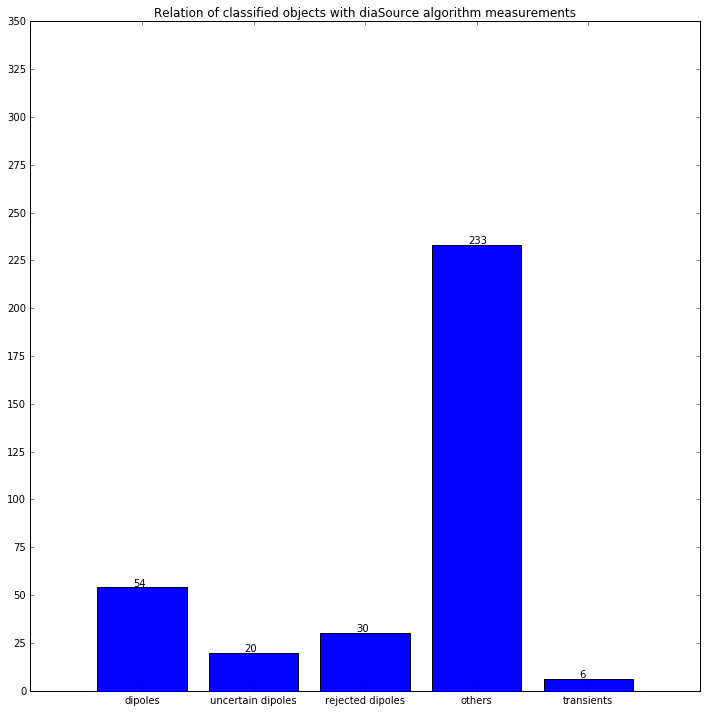

In [427]:
size = 10
p = 'b'
n = 'r'

plt.figure(figsize=(12,12))
data = [dipoles, uncertain_dipoles, rejected_dipoles, others, transients_count]
labels = ["dipoles", "uncertain dipoles", "rejected dipoles", "others", "transients"]

ind = np.arange(len(data))

p1 = plt.bar(ind, data, align='center')
ax = plt.axes()

total = sum(data)

plt.xticks(ind, labels)
plt.yticks(np.arange(0, total+10, 25))
plt.title("Relation of classified objects with diaSource algorithm measurements")


for i, rect in enumerate(p1):
    plt.text(rect.get_x()+rect.get_width()/2.5 ,rect.get_height()+1, int(rect.get_height()))


#plt.bar([i for i in range(5)],data )

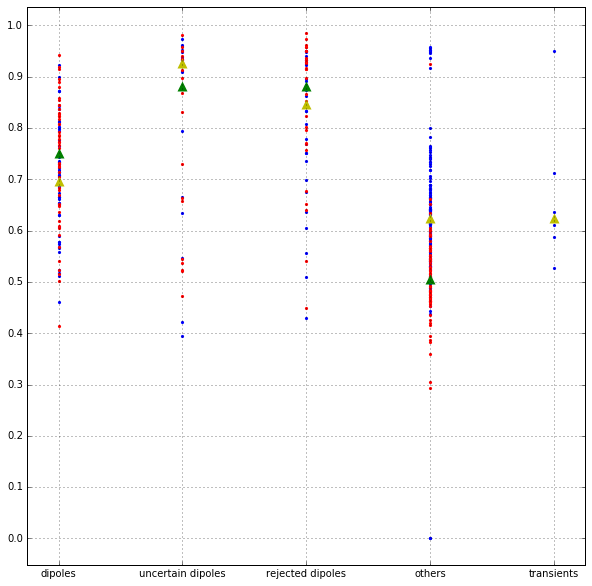

In [400]:
size = 10
p = 'b'
n = 'r'

plt.figure(figsize=(10,10))
plt.scatter([1 for val in dipoles_pos], dipoles_pos, s=size, c=p, lw=0)
plt.scatter([1 for val in dipoles_neg], dipoles_neg, s=size, c=n, lw=0)

plt.scatter([2 for val in maybe_dipoles_pos], maybe_dipoles_pos , s=size, c=p, lw=0)
plt.scatter([2 for val in maybe_dipoles_neg], maybe_dipoles_neg , s=size, c=n, lw=0)

plt.scatter([3 for val in rejected_dipoles_pos], rejected_dipoles_pos , s=size, c=p, lw=0)
plt.scatter([3 for val in rejected_dipoles_neg], rejected_dipoles_neg , s=size, c=n, lw=0)

plt.scatter([4 for val in others_pos], others_pos , s=size, c=p, lw=0)
plt.scatter([4 for val in others_neg], others_neg , s=size, c=n, lw=0)

plt.scatter([5 for val in transients], transients, s=size, lw=0)

plt.xticks([1,2,3,4, 5], ["dipoles", "uncertain dipoles", "rejected dipoles",  "others", "transients"])

plt.yticks(np.arange(0, 1.1, 0.1))

axes = plt.axes()
axes.grid(True)

positive_medians = [np.median(dipoles_pos), np.median(maybe_dipoles_pos), np.median(rejected_dipoles_pos), np.median(others_pos), np.median(transients)]
negative_medians = [np.median(dipoles_neg), np.median(maybe_dipoles_neg), np.median(rejected_dipoles_neg), np.median(others_neg)]


plt.scatter([i+1 for i in range(len(positive_medians))], positive_medians, marker="^", s=size*10, c='y', lw=0)
plt.scatter([i+1 for i in range(len(negative_medians))], negative_medians, marker="^", s=size*10, c='g', lw=0)

plt.show()

In [375]:
print np.median(dipoles_pos)
print np.median(dipoles_neg)

0.627994341328
0.653190149576


In [550]:
reload(DSTools)

<module 'DiaSourceTools' from 'DiaSourceTools.py'>

In [555]:
def get_time_mosaic(dataid_list, source, frame=1):
    mosaic = displayUtils.Mosaic(gutter=5, background=3, mode="x")
    
    
    
    for dataid in dataid_list:
        
        mosaic_temp = displayUtils.Mosaic(gutter=0, background=0, mode="y")
        
        diffExp = butler.get("deepDiff_differenceExp", dataid)
        sciExp  = butler.get("calexp", dataid)
        tmpExp = butler.get("deepDiff_warpedExp", dataid)
        bgConf = sDet.BackgroundConfig()
        background,tmpExp = sDet.estimateBackground(tmpExp,bgConf,True)
        
        s1 = DSTools.get_stamp(source, sciExp)
        s2 = DSTools.get_stamp(source, tmpExp)
        s3 = DSTools.get_stamp(source, diffExp)
        
        mosaic_temp.append(s1.getMaskedImage())
        mosaic_temp.append(s2.getMaskedImage())
        mosaic_temp.append(s3.getMaskedImage())
        m = mosaic_temp.makeMosaic(frame=None, display=None).clone()
        mosaic.append(m)
        
    mosaic.makeMosaic(frame=frame, title="time mosaic")
        

In [563]:
dataids = [{'visit': visit , 'filter':'r' , 'ccd':14} for visit in visits]
get_time_mosaic(dataids, sources_list[-1][85])

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


In [554]:
dataids

[{'ccd': 14, 'filter': 'r', 'visit': 845345},
 {'ccd': 14, 'filter': 'r', 'visit': 849373},
 {'ccd': 14, 'filter': 'r', 'visit': 849686},
 {'ccd': 14, 'filter': 'r', 'visit': 850180},
 {'ccd': 14, 'filter': 'r', 'visit': 850586},
 {'ccd': 14, 'filter': 'r', 'visit': 851060}]

In [433]:
mosaic = displayUtils.Mosaic(gutter=5, background=3, mode="x")

In [446]:
mosaic_temp = displayUtils.Mosaic(gutter=5, background=3, mode="x")
mosaic_temp.append(DSTools.get_stamp(sources[0], sciExp).getMaskedImage())

mosaic_temp.makeMosaic(frame=None, display=None)

<lsst.afw.image.imageLib.MaskedImageF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::MaskedImage< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x7fd64248b390> >

In [557]:
import lsst.afw.geom as afwGeom

exposure = butler.get("calexp", dataids[0])
offset=10
sources = sources_list[-1]
source = sources[10]

In [558]:
bbox = source.getFootprint().getBBox()

sourceRa = source.getRa()
sourceDec = source.getDec()


wcs = exposure.getWcs()


mos = displayUtils.Mosaic()


Center = afwGeom.Point2I(wcs.skyToPixel(sourceRa, sourceDec))

Begin = afwGeom.Point2D(Center.getX() - bbox.getHeight()/2., Center.getY() - bbox.getHeight()/2.)
Begin = afwGeom.Point2I(Begin)
End = afwGeom.Point2D(Center.getX() + bbox.getHeight()/2., Center.getY() + bbox.getHeight()/2.)
End = afwGeom.Point2I(End)

ExpOrig = afwGeom.Point2I(exposure.getX0()-1, exposure.getY0()-1)




correctedBegin = Begin- ExpOrig
correctedEnd = End - ExpOrig

correctedBegin= afwGeom.Point2I(correctedBegin.getX()-offset,correctedBegin.getY()-offset )
correctedEnd = afwGeom.Point2I(correctedEnd.getX()+offset,correctedEnd.getY()+offset )




bboxT = afwGeom.Box2I(correctedBegin,correctedEnd)

exp = exposure.Factory(exposure,bboxT, True)

In [559]:
ds9.mtv(exp)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


In [560]:
ds9.mtv(exposure, frame=2)


In [526]:
ds9.dot('0', Center.getX(), Center.getY(), frame=2)